In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools_Exercise_1_5 as tools
import Exercise_5_ny as model


# Exercise 5 [L3]: Gaussian Shock

## Original model

Consider the model
$$\begin{eqnarray*}
V_{t}(M_{t}) & = & \max_{C_{t}}\left\{ \frac{C_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[V_{t+1}(M_{t+1})\right]\right\} \\
 & \text{s.t.}\\
M_{t+1} & = & R(M_{t}-C_{t})+Y_{t+1}\\
Y_{t+1} & = & \exp(\xi_{t+1})\\
\xi_{t+1} & = & \mathcal{N}(0,\sigma_{\xi}^{2})\\
A_{t}=M_{t}-C_{t} & \geq & 0
\end{eqnarray*}$$

for $T=10$, $\beta=0.98$, $\rho=0.5$, $R=1.0/\beta$, and $\sigma_{\xi}=0.2$.

### 1. Solve it using Gauss-Hermite quadrature for evaluating the expectation (see algorithm 10 in lecture 3) 

In [2]:
# Set-up
class par: pass
par.beta = 0.98
par.rho = 0.5
par.R = 1.0/par.beta
par.sigma = 0.2
par.mu = 0

par.T = 10
par.num_M = 50
par.M_max = 10
par.num_shocks = 5
par.grid_M = tools.nonlinspace(1.0e-6,par.M_max,par.num_M,1.1) # non-linear spaced points: like np.linspace with unequal spacing

# load Gauss-Hermite!
x,w = tools.gauss_hermite(par.num_shocks)
par.eps = np.exp(par.sigma*np.sqrt(2)*x)
par.eps_w = w/np.sqrt(np.pi)

# demographics
par.theta0 = 0
par.theta1 = 0.2
par.N = 2

# solve the model
sol = model.solve_consumption(par)


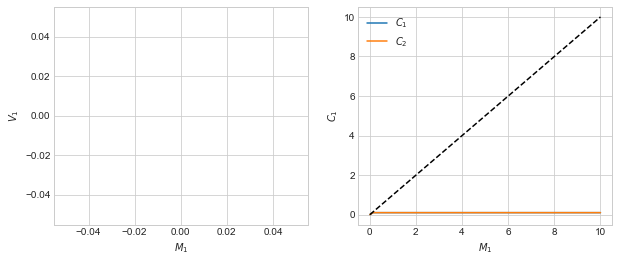

In [3]:
# Define a function for the solution
def plot_solution(sol,par,t):
    fig = plt.figure(figsize=(10,4))# figsize is in inches...
    
    ax = fig.add_subplot(1,2,1)
    ax.scatter(par.grid_M,sol.V[t])
    ax.set_xlabel(f"$M_{t+1}$")
    ax.set_ylabel(f"$V_{t+1}$")

    ax_right = fig.add_subplot(1,2,2)
    ax_right.plot(par.grid_M,sol.C1[t])
    ax_right.plot(par.grid_M,sol.C2[t])
    ax_right.plot(par.grid_M,par.grid_M,color='black',linestyle='dashed')
    ax_right.set_xlabel(f"$M_{t+1}$")
    ax_right.set_ylabel(f"$C_{t+1}$")
    ax_right.legend(['$C_1$', '$C_2$'])
    plt.show()

plot_solution(sol,par,0)


### 2. Simulate a panel of *N* household for *T* periods and plot the mean of $C_t$. Everybody should be initialized with $M_t = 1.5$

In [54]:
# Set-up
par.simN = 10000
par.M_ini = 1.5

# Allocate
class sim: pass
shape = (par.T, par.simN)
sim.M = par.M_ini*np.ones(shape)
sim.C1 = np.nan +np.zeros(shape)
sim.C2 = np.nan +np.zeros(shape)

# Simulate 
np.random.seed(2020)  #Seed value, it ensures that the computer draw the same "random"-numbers each time

for t in range(par.T):
    sim.C1[t,:] = tools.interp_linear_1d(par.grid_M, sol.C1[t,:],sim.M[t,:])
    sim.C2[t,:] = tools.interp_linear_1d(par.grid_M, sol.C2[t,:],sim.M[t,:])  # Find consumption given states
    
    if t<par.T-1:  # if not last period
        logY = np.random.normal(par.mu,par.sigma,par.simN)  # It draws random numbers from the normal distirbution
        Y = np.exp(logY)
        A = sim.M[t,:]-sim.C1[t,:]-sim.C2[t,:]
        
        sim.M[t+1,:] = par.R*A + Y # The state in the following period
     


### 3. Check that the average of $C_t$ is weakly increasing over time.

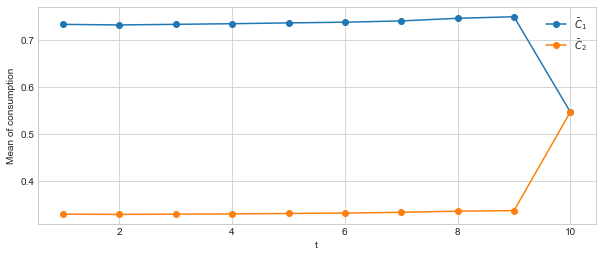

In [55]:
# Define a function for the simulation
def figure_sim(simC1,simC2,par):
    fig = plt.figure(figsize=(10,4))# figsize is in inches...
    t_grid = [t for t in range(1,par.T+1)]    
    ax = fig.add_subplot(1,1,1)
    ax.plot(t_grid,np.mean(simC1,1),'-o')
    ax.plot(t_grid,np.mean(simC2,1),'-o')
    ax.set_xlabel(f"t")
    ax.set_ylabel(f"Mean of consumption")
    #ax.set_ylim(bottom=0.5,top=0.6)
    ax.legend(["$\\bar C_1$", "$\\bar C_2$"])
    plt.show()
    
figure_sim(sim.C1,sim.C2,par)

### 4. Check that if you temporarily set $\sigma_{\xi} = 0$ then average $C_t$ is constant over time.

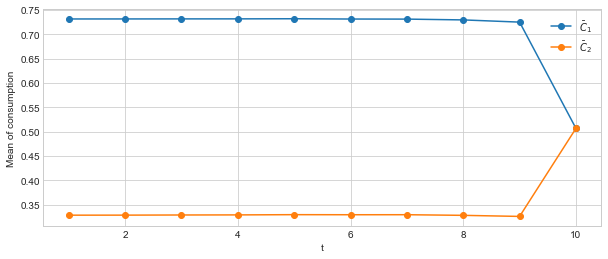

In [56]:
# We copy the class par and set sigma = 0
par_sigma_zero = type('CopyOfpar', par.__bases__, dict(par.__dict__)) 
par_sigma_zero.sigma = 0


# load Gauss-Hermite
x,w = tools.gauss_hermite(par_sigma_zero.num_shocks)
par_sigma_zero.eps = np.exp(par_sigma_zero.sigma*np.sqrt(2)*x)
par_sigma_zero.eps_w = w/np.sqrt(np.pi)

# solve model
sol_sigma_zero = model.solve_consumption(par_sigma_zero)

# Simulate
#Define a function
def simulate (par,sol):
    
    # Initialize
    class sim: pass
    shape = (par.T, par.simN)
    sim.M = par.M_ini*np.ones(shape)
    sim.C1 = np.nan +np.zeros(shape)
    sim.C2 = np.nan +np.zeros(shape)

    # Simulate 
    for t in range(par.T):
        sim.C1[t,:] = tools.interp_linear_1d(par.grid_M, sol.C1[t,:],sim.M[t,:])  #It finds consumption given states
        sim.C2[t,:] = tools.interp_linear_1d(par.grid_M, sol.C2[t,:],sim.M[t,:])  #It finds consumption given states
    
        if t<par.T-1:  # if not last period
            logY = np.random.normal(par.mu,par.sigma,par.simN)  # It draws random numbers from the normal distirbution
            Y = np.exp(logY)
            A = sim.M[t,:]-sim.C1[t,:] - sim.C2[t,:]
        
            sim.M[t+1,:] = par.R*A + Y # The state in the following period
            
     
    return sim


sim_sigma_zero = simulate(par_sigma_zero,sol_sigma_zero)

# Figure
figure_sim(sim_sigma_zero.C1,sim_sigma_zero.C2,par_sigma_zero)


### 5. Plot the value and consumption functions for multiple t – do you see any pattern?

In [ ]:
fig = plt.figure(figsize=(20,5))# figsize is in inches...

ax = fig.add_subplot(1,2,1)
for t in range(par.T):
    ax.plot(par.grid_M,sol.V[t], label=f't = {t+1}')
ax.set_xlabel(f"$M_t$")
ax.set_ylabel(f"$V_t$")
ax.set_title(f'Value function')
plt.legend(loc=2, ncol=3)

ax_right = fig.add_subplot(1,2,2)
for t in range(par.T):
    ax_right.plot(par.grid_M,sol.C[t], label=f't =  {t+1}')
ax_right.set_xlabel(f"$M_t$")
ax_right.set_ylabel(f"$C_t$")
ax_right.set_title(f'Consumption function')
plt.legend()

plt.show()

### 6. Calculate the Euler-error 


$$\begin{eqnarray*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T}  \mathbb{1}_{\{0<C_1<M_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_1<M_{it}\}} |\varepsilon_{it}|
 \end{eqnarray*}$$
 where

$$\begin{eqnarray*}
  \varepsilon_{it} \approx u'(C_{it})-\beta R \sum_{j=1}^{S} \omega_j \Big[u'\big(C_{t+1}^{\star}(R(M_{it}-C_{it})+Y_j)\big)\Big]
 \end{eqnarray*}$$
 
 and $\omega_j$ are the Gauss-Hermite weights and $Y_j$ are the associated income nodes.

In [6]:
# Define the marginal utility
def marg_util(C,par):
    y = C**(-par.rho);
    return y


# 1. Solve the model
sol = model.solve_consumption(par)

# 2. simulate
sim = simulate(par,sol)

# 3. Calculate the Euler residual
Euler_residual = np.nan + np.zeros((par.T-1,par.simN))  # Allocate space
A = np.nan + np.zeros((par.T-1,par.simN))               # Allocate space

for t in range(par.T-1):   # Sum over t (and the sum over N happens in vector notation)
    
    # Initialize
    M_next = par.grid_M
    C_next = sol.C[t+1,:]

    m = sim.M[t,:]
    c = sim.C[t,:]
    A[t,:] = m-c

    sum_mu = 0.0 # the sum of marginal utility
    
    for s,Y in enumerate(par.eps): #Loop over the G-H notes
        
        #Next period
        M_plus = par.R*A[t,:] + Y
        C_plus = tools.interp_linear_1d(M_next,C_next,M_plus) 
    
        marg_Cplus = marg_util(C_plus,par)
        
        # weight on the shock 
        w = par.eps_w[s]

        sum_mu +=w*marg_Cplus 
    
    Euler_residual[t,:] = marg_util(c,par)-par.beta*par.R*sum_mu

# 4. Calculate the average absolute euler residual
I = (A>0)   # Define an indicator for A bigger than 0 (M>C)
Euler_error = np.mean(abs(Euler_residual[I]))


print(f'The Euler error:    {Euler_error:.4f}')

The Euler error:    0.0029


### 7. Likewise calculate the normalized Euler-error


$$\begin{eqnarray*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_1<M_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} log_{10}(|\varepsilon_{it}| / C_{it}) \mathbb{1}_{0<C_1<M_{it}} 
 \end{eqnarray*}$$

and discuss what this implies for the accuracy of the solution.

In [7]:
C =(sim.C[0:par.T-1,:])  # The euler error is not defined in last period

nom_Euler_error = np.log10(abs(Euler_residual[I])/(C[I]))   
nom_Euler_error = np.mean(nom_Euler_error)


print(f'The Normalized Euler error:    {nom_Euler_error:.4f}')

The Normalized Euler error:    -2.8599


### 8. Look at how the Euler-errors change when you vary the number of grid points. *Ensure that you are able to get an normalized Euler error smaller than at least $−3.0$*.

In [8]:
# Define functions

#Function for Setup
def setup():
    class par: pass
    par.beta = 0.98
    par.rho = 0.5
    par.R = 1.0/par.beta
    par.sigma = 0.2
    par.mu = 0

    par.T = 10
    par.num_M = 50
    par.num_shocks = 5
    par.grid_M = tools.nonlinspace(1.0e-6,10,par.num_M,1.1) # non-linear spaced points: like np.linspace with unequal spacing

    # Simulation parameters
    par.simN = 10000
    par.M_ini = 1.5

    #Gauss-Hermite
    x,w = tools.gauss_hermite(par.num_shocks)
    par.eps = np.exp(par.sigma*np.sqrt(2)*x)
    par.eps_w = w/np.sqrt(np.pi)
    
    return par

#Function for Euler Error
def Euler_error(par, sol, sim):
    Euler_residual = np.nan + np.zeros((par.T-1,par.simN))
    A = np.nan + np.zeros((par.T-1,par.simN))

    for t in range(par.T-1): # Sum over t (and the sum over N happens in vector notation)
        M_next = par.grid_M
        C_next = sol.C[t+1,:]

        m = sim.M[t,:]
        c = sim.C[t,:]
        A[t,:] = m-c

        sum_mu = 0.0
        for s,Y in enumerate(par.eps): #Loop over the G-H notes
        
            M_plus = par.R*A[t,:] + Y
            C_plus = tools.interp_linear_1d(M_next,C_next,M_plus) 
    
            marg_Cplus = marg_util(C_plus,par)
            # weight on the shock 
            w = par.eps_w[s]

            sum_mu +=w*marg_Cplus 
    
        Euler_residual[t,:] = marg_util(c,par)-par.beta*par.R*sum_mu
    
    
    I = (A>0)   
    Euler_error = np.mean(abs(Euler_residual[I]))
    
    C =(sim.C[0:par.T-1,:])

    nom_Euler_error = np.log10(abs(Euler_residual[I])/(C[I]))   
    nom_Euler_error = np.mean(nom_Euler_error)
    
    print(f'Number of grid points:         {pars.num_M} ')
    print(f'The Euler error:               {Euler_error:.4f}')
    print(f'The Normalized Euler error:    {nom_Euler_error:.4f}', end ='\n\n')

In [9]:
# Find the Euler Error for different grid points

#Array of grid points    
grid_points = [10,20,40,50,70,100,1000]

for i,grid_point in enumerate(grid_points):
    # setup
    pars = setup()
    pars.num_M = grid_point
    pars.grid_M = tools.nonlinspace(1.0e-6,10,pars.num_M,1.1) # non-linear spaced points: like np.linspace with unequal spacing

    # solve
    sols = model.solve_consumption(pars)

    # simulate
    sims = simulate(pars,sols)

    # calculate the errors
    Euler_error(pars, sols, sims)

Number of grid points:         10 
The Euler error:               0.0216
The Normalized Euler error:    -1.9643

Number of grid points:         20 
The Euler error:               0.0097
The Normalized Euler error:    -2.3872

Number of grid points:         40 
The Euler error:               0.0039
The Normalized Euler error:    -2.8104

Number of grid points:         50 
The Euler error:               0.0028
The Normalized Euler error:    -2.8610

Number of grid points:         70 
The Euler error:               0.0021
The Normalized Euler error:    -2.9773

Number of grid points:         100 
The Euler error:               0.0013
The Normalized Euler error:    -3.2439

Number of grid points:         1000 
The Euler error:               0.0001
The Normalized Euler error:    -4.0807

